In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt

import load_month
import os
loader = load_month.TripsLoader()

In [2]:
regs = np.loadtxt('data/regs.txt', delimiter=',', dtype=np.int)
print(regs)

[1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174
 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224
 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278
 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333
 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385
 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441
 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068
 2069 2118 2119 2168]


In [159]:
l_parse_dates = [u'tpep_pickup_datetime']
l_index_col = ['tpep_pickup_datetime']

df = pd.read_csv('data/ytd_may15.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00,40,32,7,17,60,129,153,271,294,70,...,8,17,10,639,437,230,15,271,90,123
2015-06-01 01:00:00,17,20,5,13,38,90,111,163,246,28,...,6,7,22,547,490,212,21,237,124,119
2015-06-01 02:00:00,5,5,0,8,25,47,97,139,207,25,...,6,11,10,234,215,95,69,253,105,112
2015-06-01 03:00:00,5,6,0,6,27,26,68,77,208,29,...,13,0,2,84,10,17,6,78,3,94
2015-06-01 04:00:00,8,16,2,6,21,39,53,81,109,8,...,20,1,0,9,4,14,5,62,1,1


In [4]:
import holidays #каникулы pip install holidays
hol = holidays.US(state='NY', years=range(2015, 2020))
tkd = []
for date, name in hol.items():
    if name in ('Thanksgiving', 'Memorial Day', 'Labor Day'):
        tkd.append(date)
tkd.sort()

In [5]:
k_list = [1, 5, 7]

# функция получения абсолютного времени
def get_t(dt_index):
    t = dt_index - datetime(2015, 6, 1, 0, 0, 0)
    t = t.days*24 + t.seconds // 3600
    return t


In [6]:
#  функция получения массива признаков X
def get_X(df):
    tt = get_t(df.index)
    t = tt.values * np.pi / 168 * 2
    l = []
    for k in k_list:
        l.append(np.sin(t * k))
        l.append(np.cos(t * k))


    # прирост в полпроцента и смягчение выбросов даст учет праздников
    # праздники 4 июля, рождество, день памяти повышенный спрос
    l.append([1 if (x.month == 7 and x.day == 4) \
              or (x.month == 12 and x.day in (24, 25, 26, 31)) \
              or (x.month == 1 and x.day == 1 and x.hour >= 8) \
              or (x.month == 5 and x.day >= 22 and x.date in tkd) \
              or (x.month == 9 and x.day <= 10 and x.date in tkd) \
              else 0 for x in df.index])
    # в первые два часа после хелоуина меньше спрос и первые 3 часа нового года и в день благодарения
    l.append([1 if (x.month == 1 and x.day == 1 and x.hour <= 4) \
              or (x.month == 11 and x.day == 1 and x.hour < 3)
              or (x.month == 11 and x.day >= 22 and x.date in tkd and x.hour < 15 and x.hour > 7)
              else 0 for x in df.index])
    # 23 января была сильная метель. допустим мы можем получать сводку от метеорологов для учета данного обстоятельства
    # плюс мы уберем сильный выброс
    l.append([1 if (x.year == 2016 and x.month == 1 and x.day == 23 and x.hour >=10) \
              or (x.year == 2016 and x.month == 1 and x.day == 24 and x.hour <=12)
              else 0 for x in df.index])

    for d in range(7):
        l.append([1 if x.weekday() == d else 0 for x in df.index])
    
    
    for d in range(24):
        l.append([1 if x.hour == d else 0 for x in df.index])

    t = np.arange(df.shape[0]) * np.pi / 8760 * 2
    l.append(np.sin(t))
    l.append(np.cos(t))
    l.append(np.sin(t * 2))
    l.append(np.cos(t * 2))
    X = np.array(l).T
    return X

In [112]:

#  функция получения массива X с новыми признаками
def get_X_shifted(df, col):
    X = get_X(df)
    
    # количество поездок из рассматриваемого района в моменты времени y_T, y_{T-1}, y_{T-K}y
    # (параметр K можно подбирать; попробуйте начать, например, с 6)
    for i in range(1, 13):
        to_stack = df[col].shift(i).values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
    
    # количество поездок из рассматриваемого района в моменты времени y_{T-24}, y_{T-48}, y_{T-24*K_d}
    # (параметр K_d можно подбирать; попробуйте начать, например, с 2)
    for i in range(1, 8):
        to_stack = df[col].shift(24*i).values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
        
    # суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю
    for window in [12, 24, 168]:
        r = df[col].shift(1).rolling(window=window, min_periods=window)
        to_stack = r.sum().values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
    
    
    return X

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

In [114]:
tests = np.random.choice(regs, 10)
print(tests)

[1232 1480 1383 1376 1272 1126 1283 1439 1387 1630]


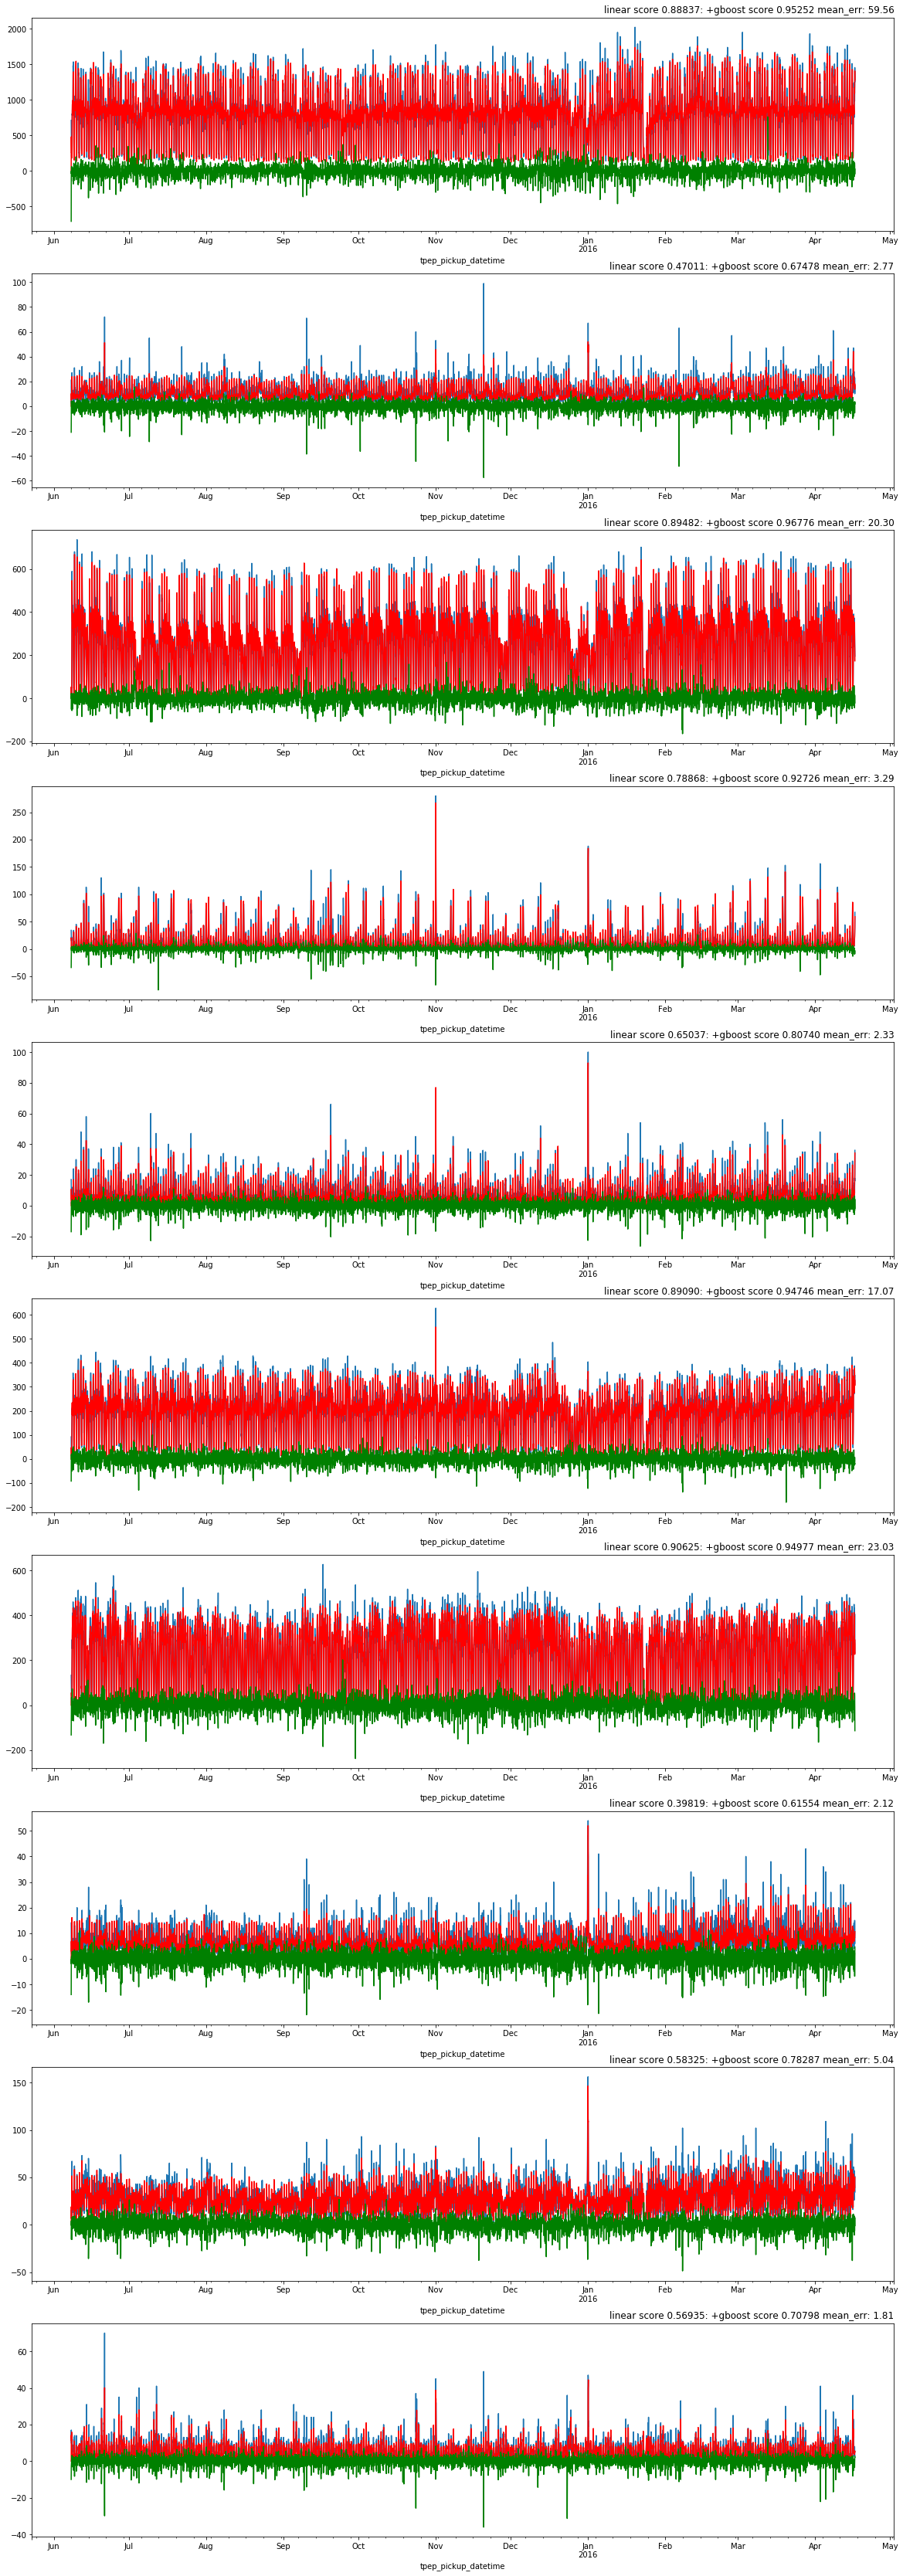

CPU times: user 30.1 s, sys: 354 ms, total: 30.5 s
Wall time: 27.7 s


In [140]:
%%time
model = LinearRegression()
gmodel = GradientBoostingRegressor(n_estimators=200)
fig, axes = plt.subplots(10, 1, figsize=(20,60))
start = 168
end = -168*2
df['pred'] = 0
df['gpred'] = 0

l_g_score = []
for ind, i in enumerate(tests):
    col = str(i)
    ax = axes[ind]
    X = get_X_shifted(df, col)
        
    X = X[start:end, :]
    Y = df[col].shift(-1)[start:end].values
    # линейная модель для выявления зависимостей общих зависимостей
    model.fit(X, Y)
    lpreds = model.predict(X)
    title = "linear score %.5f:"%r2_score(Y, lpreds)
    
    df['pred'] = 0
    
    # обучаем гбуст на отсатках
    Y_res = (Y - lpreds)
    gmodel.fit(X, Y_res)
    gpreds = gmodel.predict(X)
    
    # совмещаем прогнозы
    preds = lpreds + gpreds
    df.loc[start:end, ['pred']] = preds
    df['pred'] = df['pred'].shift(1)
    
    score = r2_score(Y, preds)
    title += " +gboost score %.5f"%score
    mean_err = np.abs(Y - preds).mean()
    title += " mean_err: %.2f" % mean_err
    ax.set_title(title , loc='right')
    l_g_score.append(score)
    
    df['dif'] = (df['pred']-df[col])
    df[col][start:end].plot(ax=ax)
    df['pred'][start:end].plot(ax=ax, color='r')
    df['dif'][start:end].plot(ax=ax, color='g')
    

plt.show()


CPU times: user 28.2 s, sys: 197 ms, total: 28.4 s
Wall time: 25.5 s


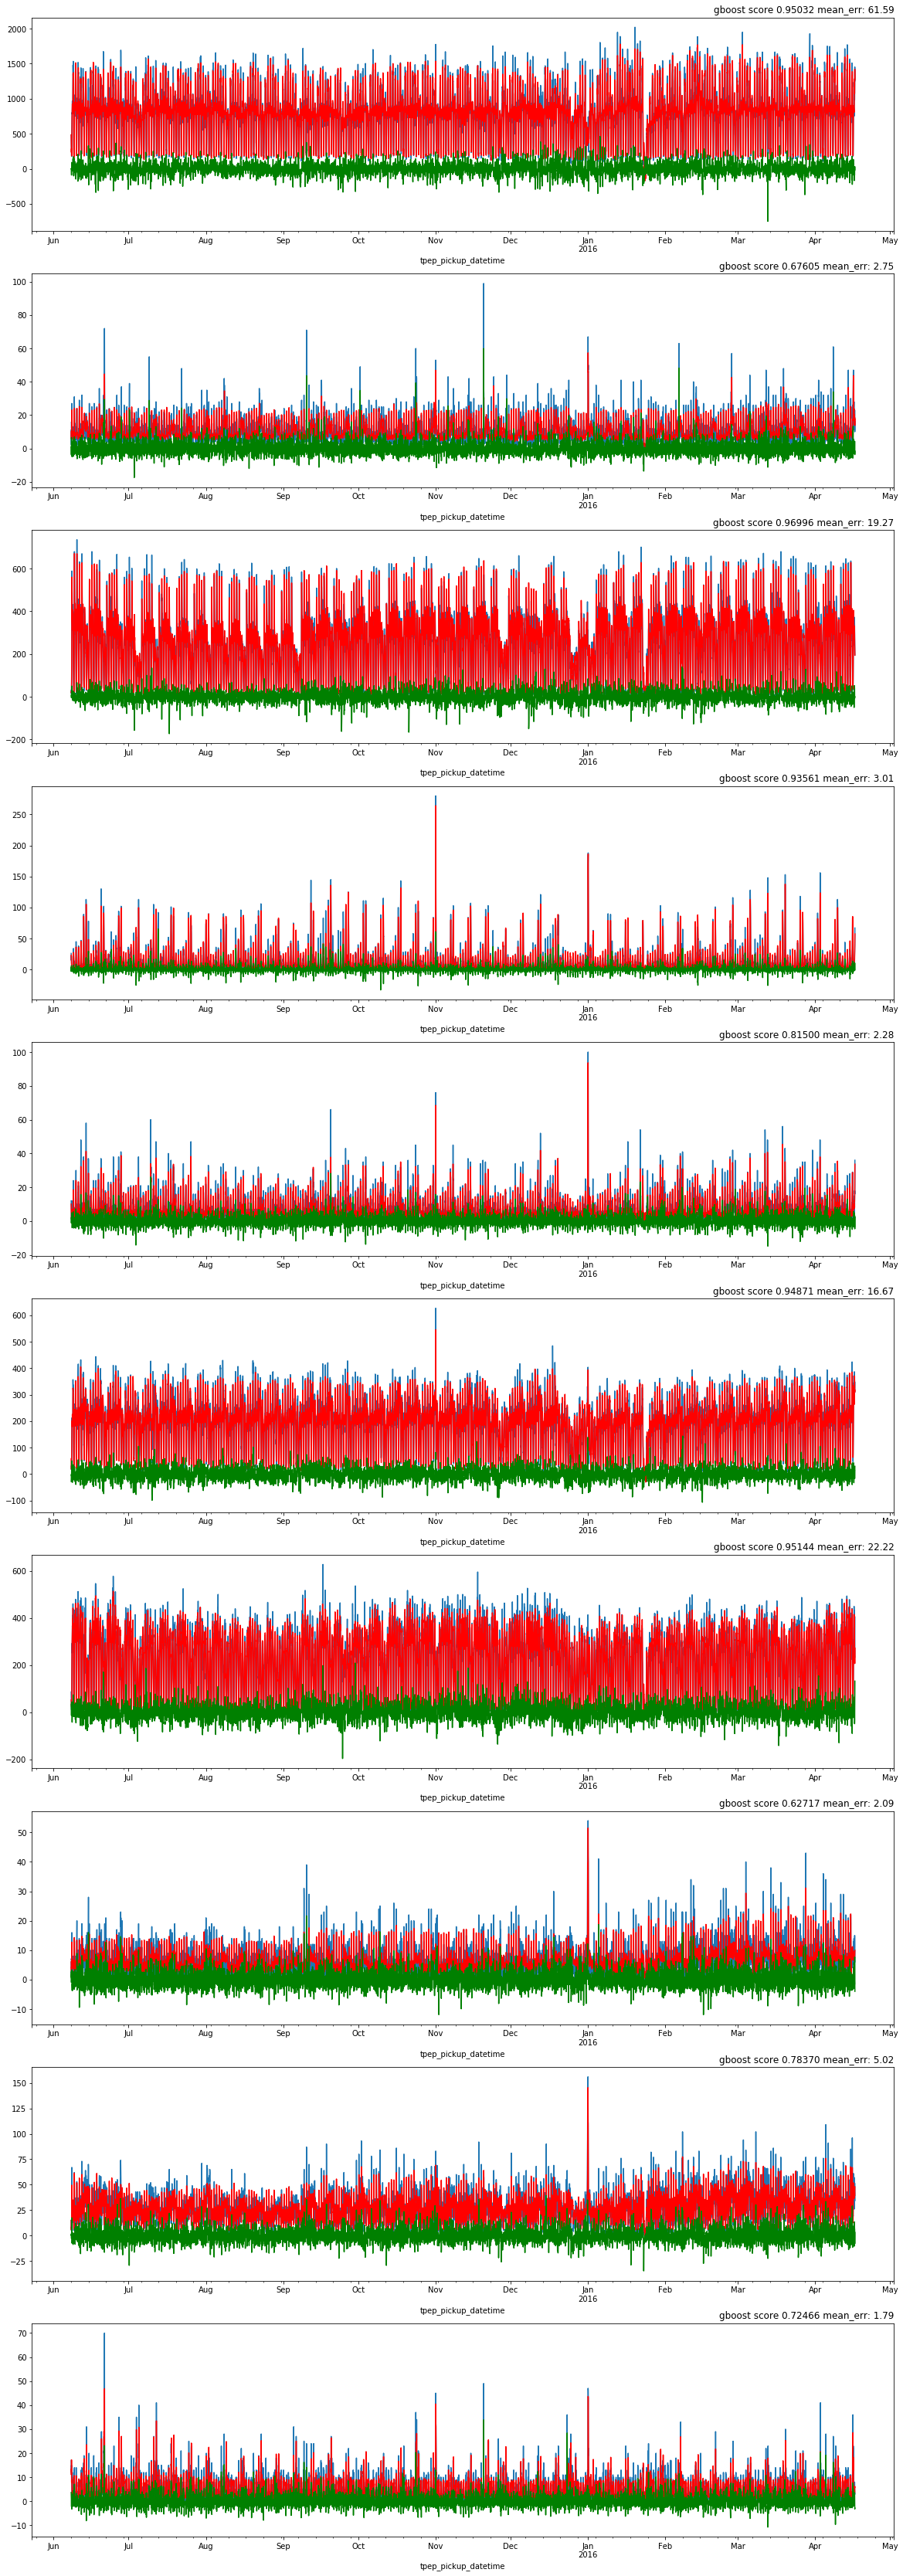

In [142]:
%%time
gmodel = GradientBoostingRegressor(n_estimators=200)
fig, axes = plt.subplots(10, 1, figsize=(20,60))
start = 168
end = -168*2
g_score = []

for ind, i in enumerate(tests):
    col = str(i)
    ax = axes[ind]
    X = get_X_shifted(df, col)
    
    X = X[start:end, :]
    #  1 hour forward
    Y = df[col].shift(-1)[start:end].values
    
    gmodel.fit(X, Y)
    preds = gmodel.predict(X)
    score = r2_score(Y, preds)
    g_score.append(score)
    
    df['pred'] = 0
    df.loc[start:end, ['pred']] = preds
    df['pred'] = df['pred'].shift(1)
    df['dif'] = (df[col] - df['pred'])
    
    # plots
    title = "gboost score %.5f"%score
    mean_err = np.abs(Y - preds).mean()
    title += " mean_err: %.2f" % mean_err
    
    df[col][start+1:end].plot(ax=ax)
    df['pred'][start+1:end].plot(ax=ax, color='r')
    df['dif'][start+1:end].plot(ax=ax, color='g')
    ax.set_title(title, loc='right')


In [146]:
print("\t".join('%.3f'%x for x in l_g_score))
print("\t".join('%.3f'%x for x in g_score))

0.953	0.675	0.968	0.927	0.807	0.947	0.950	0.616	0.783	0.708
0.950	0.676	0.970	0.936	0.815	0.949	0.951	0.627	0.784	0.725


In [144]:
dif = np.array(l_g_score) - np.array(g_score)
print(dif)

[ 0.00219821 -0.00127323 -0.00219222 -0.00834362 -0.00760397 -0.00124507
 -0.00166911 -0.01163429 -0.00082564 -0.01667463]


In [145]:
dif.mean()
# градиентный бустинг быстрее и ненмого точнее. соберем показатели по 6 моделям на +1, +2 ... +6 часов

-0.004926357497359035

In [153]:
%%time
gmodel = GradientBoostingRegressor(n_estimators=300)
start = 168
end = -168*2
g_score = np.zeros((6, 10))
mean_err = np.zeros((6, 10))
for t in range(1, 7):
    for ind, i in enumerate(tests):
        col = str(i)
        X = get_X_shifted(df, col)

        X = X[start:end, :]
        #  1 hour forward
        Y = df[col].shift(-t)[start:end].values

        gmodel.fit(X, Y)
        preds = gmodel.predict(X)
        score = r2_score(Y, preds)
        g_score[t-1, ind]=score
        mean_err[t-1, ind] = np.abs(Y - preds).mean()

CPU times: user 3min 31s, sys: 1.53 s, total: 3min 32s
Wall time: 3min 25s


In [155]:
print(g_score.mean(axis = 0))
print(g_score.std(axis=0))
print(g_score.mean(axis = 1))
# модели дает весьма стабильные прогнозы в независимости от сдвига
# все работает намного быстрее, чем с АРИМА, так что отказ от добавления региона
# как категориального признака утраиюващего размерность оправдан

[0.95593691 0.71545878 0.97182128 0.93625055 0.82223993 0.95159217
 0.95683912 0.66266318 0.81534266 0.7511314 ]
[0.0016889  0.00264098 0.00146557 0.00538773 0.00741898 0.00240693
 0.00108485 0.00314326 0.0034263  0.00459923]
[0.85856356 0.85475362 0.85360577 0.85323023 0.85214804 0.85126437]


In [160]:
reg = '1232'
timerange = pd.DatetimeIndex(freq='1H', start = '2016-04-30 23:00:00', end='2016-05-31 17:00:00')
df_may = pd.DataFrame(index=timerange)
X_may = get_X(df_may)

In [176]:
%%time
gmodel = GradientBoostingRegressor(n_estimators=300)
start = 168
end = -168*2

X = get_X_shifted(df, col)
X = X[start:end, :]
y = []
for t in range(1, 7):
    Y = df[col].shift(-t)[start:end].values
    gmodel.fit(X, Y)
    preds = df[col].values
    for j in range(X_may.shape[0]):
        x = X_may[j, :]
        x_d = np.array([preds[-i] for i in range(1, 13)])
        x_w = np.array([preds[-24*i] for i in range(1, 8)])
        x_r = np.array([preds[-12:].sum(), preds[-24:].sum(), preds[-168:].sum()])
        x = np.hstack((x, x_d, x_w, x_r))
        preds = np.append(preds, gmodel.predict([x])[0])



CPU times: user 18.3 s, sys: 81.9 ms, total: 18.3 s
Wall time: 18.3 s


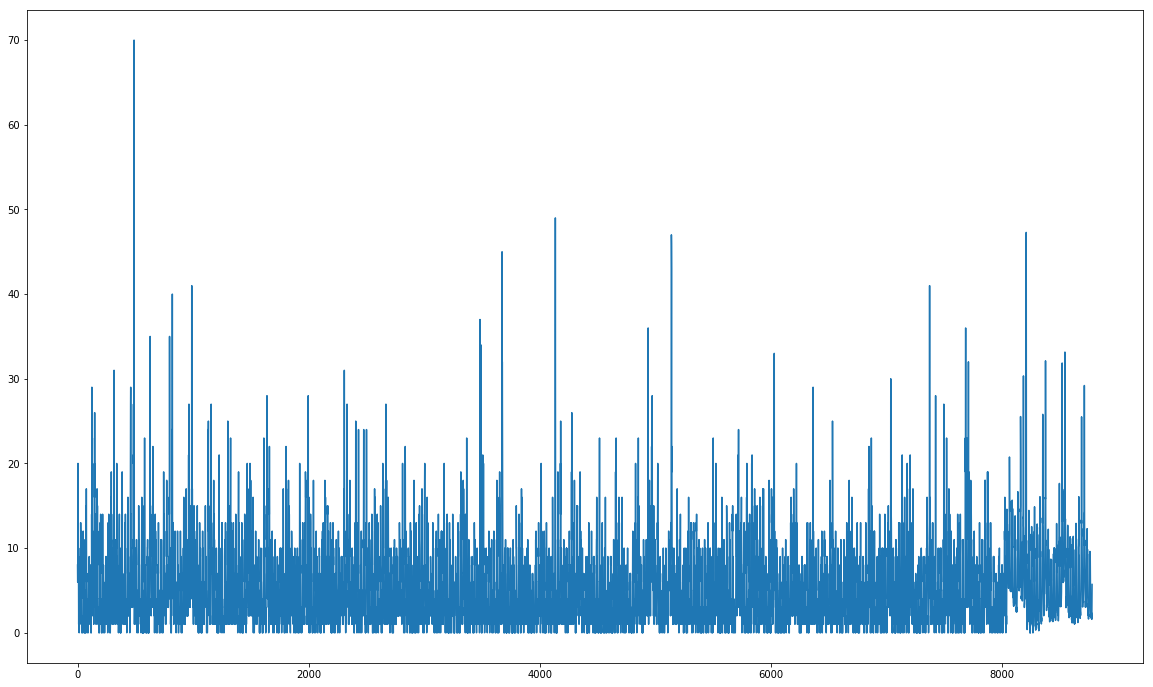

In [177]:
plt.figure(figsize=(20,12))
plt.plot(preds)

In [173]:
gmodel.feature_importances_

array([4.15536515e-02, 1.94811196e-02, 1.80641659e-02, 1.46114738e-02,
       3.26341118e-02, 4.35274371e-02, 1.75113219e-02, 2.14485523e-03,
       6.99534361e-03, 0.00000000e+00, 8.74567565e-05, 8.57394894e-05,
       0.00000000e+00, 0.00000000e+00, 6.45957589e-03, 2.51672280e-03,
       3.89395571e-03, 1.82026034e-02, 2.38668600e-03, 4.29216913e-04,
       1.06653093e-03, 2.95563889e-03, 4.15211686e-04, 0.00000000e+00,
       3.12267353e-04, 2.51992902e-04, 5.52525793e-04, 5.86639763e-03,
       0.00000000e+00, 0.00000000e+00, 9.23587171e-04, 0.00000000e+00,
       1.95769670e-04, 1.59286934e-03, 1.41393554e-03, 9.26441017e-03,
       3.08136896e-03, 2.72566516e-03, 2.46663939e-02, 3.01363519e-03,
       6.19311109e-02, 9.17332279e-02, 5.99837692e-02, 3.07932147e-02,
       2.30119478e-02, 2.90070374e-02, 1.46967790e-02, 5.76698471e-03,
       1.53486948e-02, 2.24223564e-02, 1.42363694e-02, 1.62952040e-02,
       1.68342848e-02, 1.34451774e-02, 1.47275987e-02, 1.38623812e-02,
      